# Access the database
* 1.368.235.072 Commits
*    32.411.734 Users
*   125.486.232 Projects

In [48]:
import numpy as numpy
import matplotlib.pyplot as pyplot

In [10]:
%load_ext autoreload
%aimport dbUtils
%autoreload 1

In [2]:
dbUtils.runQuery('''
    select column_name, data_type from information_schema.columns
    where table_name = 'commits';
''')

Time used: 0.3947935104370117


,column_name,data_type
0,id,integer
1,author_id,integer
2,committer_id,integer
3,project_id,integer
4,created_at,timestamp without time zone
5,sha,character varying


___

### Get sample users: 
VIEW crm20.lb_sample_users

In [47]:
dbUtils.runQuery('''
    CREATE TABLE crm20.lb_sample_users AS
    (SELECT id FROM ght.users WHERE MOD(id, 1221) = 5 AND type = 'USR');
    SELECT * FROM crm20.lb_sample_users
''')

Time used: 15.170296669006348


,id
0,40898621
1,40899842
2,40901063
3,40902284
4,40903505
...,...
25596,40890074
25597,40892516
25598,40891295
25599,40896179


In [93]:
sampleUsers = dbUtils.runQuery('''
    DELETE FROM crm20.lb_sample_users;
    
    INSERT INTO crm20.lb_sample_users
    SELECT id 
    FROM ght.users 
    WHERE MOD(id, 113) = 5 
    AND type = 'USR';
    
    SELECT * FROM crm20.lb_sample_users
''')
display(sampleUsers)

Time used: 20.39828372001648


,id
0,40898095
1,40898208
2,40898321
3,40898434
4,40898547
...,...
275661,40897530
275662,40897643
275663,40897756
275664,40897869


### Update all views

In [ ]:
matViews = dbUtils.runQuery('''
    SELECT matviewname::TEXT AS name
    FROM pg_matviews
    WHERE schemaname = 'crm20'
    AND matviewname::TEXT LIKE 'lb%%'
''')['name']
for matView in matViews:
    print('Updating matView '+matView)
    dbUtils.runQuery('''
        REFRESH MATERIALIZED VIEW crm20.{name}; 
        SELECT count(*) FROM crm20.{name}
    '''.format(name=matView))

Time used: 0.05512547492980957


Updating matView lb_sample_commits_all
Time used: 1876.2644941806793


Updating matView lb_sample_commits
Time used: 14170.458399534225


Updating matView lb_sample_projects
Time used: 3.5932347774505615


Updating matView lb_languages
Time used: 0.46927762031555176


Updating matView lb_polyglots
Time used: 0.021283864974975586


Updating matView lb_changes


### Get projects the sample users worked on:
VIEW crm20.lb_sample_projects

In [113]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_projects CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_sample_projects AS
    (SELECT DISTINCT repo_id
    FROM lb_sample_users, ght.project_members 
    WHERE id = user_id);
    SELECT * FROM crm20.lb_sample_projects
''')

Time used: 4.75212287902832


,repo_id
0,3
1,64
2,108
3,190
4,202
...,...
117444,137595214
117445,137596666
117446,137599553
117447,137600746


### Commits in that repos

VIEW crm20.lb_sample_commits_all

In [114]:
dbUtils.runQuery('''
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits_all AS
    (SELECT commit_id 
    FROM ght.project_commits, crm20.lb_sample_projects
    WHERE project_id = repo_id );
    SELECT * FROM crm20.lb_sample_commits_all
''')

Time used: 1767.0496952533722


,commit_id
0,1416368
1,1416382
2,1416395
3,1416404
4,1416417
...,...
23551227,1384234
23551228,1384248
23551229,1384267
23551230,1384284


In [115]:
dbUtils.runQuery('''
    SELECT * FROM crm20.lb_sample_commits_all
''')

Time used: 33.247191190719604


,commit_id
0,1416368
1,1416382
2,1416395
3,1416404
4,1416417
...,...
23551227,1384234
23551228,1384248
23551229,1384267
23551230,1384284


### Commits in that repos from sample users

VIEW crm20.lb_sample_commits

In [116]:

dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_sample_commits;
    
    CREATE MATERIALIZED VIEW crm20.lb_sample_commits AS
    (SELECT commit_id, sha, author_id, created_at, project_id 
    FROM crm20.lb_sample_commits_all, ght.commits
    WHERE commit_id = id AND author_id IN (SELECT * FROM crm20.lb_sample_users));
    
    SELECT * FROM crm20.lb_sample_commits
''')

Time used: 14960.551239490509


,commit_id,sha,author_id,created_at,project_id
0,1435452,81686ad9a666703b2238028644f284df02b0b274,250526,2012-07-31 23:09:37,79481.0
1,1434138,ade8d5e4236a13725017955b6690e2bc1b885ea0,26108,2012-06-23 09:28:26,79414.0
2,1434139,5687e91cae555337d278ceb782e759dec0e09592,26108,2012-06-23 09:18:42,79414.0
3,1434140,a3bc7dca9ec56a06a0c566128230717d26be4943,26108,2012-06-23 09:16:14,79414.0
4,1434141,83db98a5421b43bdc8f586796e1890175e3f47d1,26108,2012-06-23 09:15:16,79414.0
...,...,...,...,...,...
1492954,1384234,8660bae7a7609e60a411bed6dc292e72c75898e9,243746,2012-01-19 16:10:34,77651.0
1492955,1384248,53af9d9e9e44045b786867bbd0f51e25e7c6c7ab,243746,2012-01-19 16:07:41,77651.0
1492956,1384267,1c5aaa1ada1ff6ea575ed19e0ea667f067bb6bd4,243746,2012-01-15 09:08:58,77651.0
1492957,1384284,f30cedcf9583401914261b662906a32b9cd17a2a,243746,2012-01-14 12:00:23,77651.0


## Question: How does ght.raw_patches count deletions and changes?

In [131]:
dbUtils.runQuery('''
    SELECT *
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,sha,name,previous_filename,changes,deletions,status,patch
0,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,29,13,modified,"@@ -17,12 +17,16 @@\n \n import java.util.List..."
1,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,43,7,modified,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit..."
2,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,33,0,added,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti..."
3,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,17,4,modified,"@@ -21,6 +21,7 @@\n import org.glite.security...."
4,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,7,1,modified,"@@ -99,10 +99,13 @@ public void checkOrgDBConn..."
5,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/java/org/glite/secu...,,46,34,modified,"@@ -63,41 +63,14 @@ protected void synchronize..."
6,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,16617,0,added,
7,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/jq...,,1225,0,added,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -..."
8,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,
9,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,voms-admin-server/src/main/webapp/jquery-ui/im...,,0,0,added,


In [129]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.commits
    WHERE sha='95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
''', True)

,id,sha,author_id,committer_id,project_id,created_at
0,650784538,95b5c803ccfc8ae3c015a4681ec14f5b2579896a,119958,30351173,1586836,2017-03-23 19:55:24


In [130]:
dbUtils.runQuery('''
    SELECT * 
    FROM ght.projects
    WHERE id='1586836'
''', True)['url'][0]

'https://api.github.com/repos/italiangrid/voms-admin-server'

See https://github.com/italiangrid/voms-admin-server/commit/95b5c803ccfc8ae3c015a4681ec14f5b2579896a:
For Docker-compose: Changes = Additions + Deletions, but: Changed lines have updates and deletes so count twice
configure-vo.sh was completely deleted, so changes = deletions

In [246]:
dbUtils.runQuery('''
    SELECT name, patch, (SELECT COUNT(*) FROM REGEXP_MATCHES(patch, '^\+', 'gn')) as occ
    FROM ght.raw_patches
    WHERE sha = '95b5c803ccfc8ae3c015a4681ec14f5b2579896a'
    LIMIT 20
''', True)

,name,patch,occ
0,voms-admin-server/src/main/java/org/glite/secu...,"@@ -17,12 +17,16 @@\n \n import java.util.List...",16
1,voms-admin-server/src/main/java/org/glite/secu...,"@@ -24,8 +24,11 @@\n import org.hibernate.Crit...",36
2,voms-admin-server/src/main/java/org/glite/secu...,"@@ -0,0 +1,33 @@\n+/**\n+ * Copyright (c) Isti...",33
3,voms-admin-server/src/main/java/org/glite/secu...,"@@ -21,6 +21,7 @@\n import org.glite.security....",13
4,voms-admin-server/src/main/java/org/glite/secu...,"@@ -99,10 +99,13 @@ public void checkOrgDBConn...",6
5,voms-admin-server/src/main/java/org/glite/secu...,"@@ -63,41 +63,14 @@ protected void synchronize...",12
6,voms-admin-server/src/main/webapp/jquery-ui/jq...,,0
7,voms-admin-server/src/main/webapp/jquery-ui/jq...,"@@ -0,0 +1,1225 @@\n+/*! jQuery UI - v1.11.4 -...",1225
8,voms-admin-server/src/main/webapp/jquery-ui/im...,,0
9,voms-admin-server/src/main/webapp/jquery-ui/im...,,0


## Commit Data with languages (file endings) and loc

In [ ]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_changes CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_changes AS
        (SELECT commit_id, lb_sample_commits.sha, SUM(changes-deletions) AS loc, SUBSTRING(name from '\.([^\.]*)$') AS language
        FROM crm20.lb_sample_commits, ght.raw_patches
        WHERE lb_sample_commits.sha = raw_patches.sha
        GROUP BY commit_id, lb_sample_commits.sha, language);
    SELECT * FROM crm20.lb_changes
''')

Simple table to get extended commit data:

In [ ]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_java_changes CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_java_changes AS
        (SELECT lb_java_commits.sha, SUM(changes) AS changes, SUM(deletions) AS deletions
        FROM crm20.lb_java_commits, ght.raw_patches
        WHERE lb_java_commits.sha = raw_patches.sha
        AND SUBSTRING(name from '\.([^\.]*)$') = 'java'
        GROUP BY lb_java_commits.sha);
    SELECT * FROM crm20.lb_java_changes
''')

In [205]:
dbUtils.runQuery('''
    SELECT * FROM crm20.lb_java_changes
''')

Time used: 0.20070958137512207


,sha,changes,deletions
0,000087d0ec3a5150cd62626532a55d2f9b01ac44,281,0
1,0001ee3a5ef8cce6af15fdf5a166cc412ae56c03,102,1
2,00028564cff8673f1a0d63b9de5c4c3b22f568f4,349,115
3,000319b59663f860d5d3436a9f1866f12064a5c5,8,5
4,00036f80dd5037f486bc079676a333d4bbc2ee3b,229,34
...,...,...,...
121163,fffdd5712ac1a4a03ae91e18b546d3a5ea22b384,49,17
121164,fffdf1de02630b7b0199876ac5ba01710c753412,27,4
121165,fffe13512522c846df6623596b32f40de98c0704,255,113
121166,fffe243ebccf6cd91435808b8cc26f3e4f42a31c,2,1


In [200]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_java_commits CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_java_commits AS
        (SELECT DISTINCT lb_sample_commits.*, lb_changes.loc
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.sha = lb_changes.sha
        AND language = 'java');
    SELECT * FROM crm20.lb_java_commits
''')

Time used: 1.2310984134674072


,commit_id,sha,author_id,created_at,project_id,loc
0,34110,22b221f98ca36f25acaf5739895219c87de34959,10514,2012-03-14 20:59:14,1957.0,90
1,47156,152ea721b0314e4c4ce1e39325b811142d21df53,13678,2012-07-19 10:33:05,2841.0,2
2,79804,3db954ec85e54e607ac5b4d79521b4b3faf93403,22266,2012-07-17 14:25:51,4751.0,68
3,79817,45aaedbceca8105f09e7d1df99b6659f5cc58f05,22266,2012-07-17 13:50:00,4751.0,230
4,79823,9db96dd863ddd0ee54bb0b4a1ea9c7c33e677d34,22266,2012-07-17 13:47:26,4751.0,300
...,...,...,...,...,...,...
121163,1415240447,ac7ef8ea30eeb968d88d9d645b3c7e94931e5a37,33601459,2019-05-31 20:24:52,135983058.0,6
121164,1415341514,2e7cc7a916c9c26b64ff82d3fdb672b53c7280a8,45212887,2019-05-31 22:13:25,133587874.0,10
121165,1415377389,e7854070fbb5d8ce28aea60eb6885fce3d1f3b53,41376650,2019-05-31 23:19:34,136255005.0,299
121166,1415379870,49d225b64bcc4dd96a173da2851bcab77527c38a,41376650,2019-05-31 23:22:37,136255005.0,312


## Which author did which languages (file endings)?

In [136]:
dbUtils.runQuery('''
    DROP MATERIALIZED VIEW IF EXISTS crm20.lb_languages CASCADE;
    CREATE MATERIALIZED VIEW crm20.lb_languages AS
        (SELECT author_id, language, SUM(loc) AS loc, MIN(created_at) as first_written
        FROM crm20.lb_sample_commits, crm20.lb_changes
        WHERE lb_sample_commits.commit_id = lb_changes.commit_id
        GROUP BY author_id, language);
        
    SELECT * FROM crm20.lb_languages
''')

Time used: 4.223039150238037


,author_id,language,loc,first_written
0,5,2,6.0,2014-04-07 12:09:46
1,5,au,1.0,2011-03-13 16:26:02
2,5,cn,1.0,2011-03-13 16:26:02
3,5,com/bluele/slack/LICENSE,0.0,2018-11-16 11:26:22
4,5,com/google/go-querystring/LICENSE,27.0,2017-02-09 10:59:19
...,...,...,...,...
332356,51673097,css,569.0,2019-05-30 21:09:03
332357,51673097,html,168.0,2019-05-30 21:09:03
332358,51673097,js,121.0,2019-05-30 21:09:03
332359,51673097,png,0.0,2019-05-30 21:09:03


In [101]:
dbUtils.runQuery('''
    SELECT * FROM crm20.lb_languages
''')

ProgrammingError: (psycopg2.errors.UndefinedTable) relation "crm20.lb_languages" does not exist
LINE 2:     SELECT * FROM crm20.lb_languages
                          ^

[SQL: 
    SELECT * FROM crm20.lb_languages
]
(Background on this error at: http://sqlalche.me/e/f405)

Question: How many sample commits are there, where we do not have patch data to?

In [188]:
dbUtils.runQuery('''
    SELECT lb_sample_commits.commit_id
    FROM crm20.lb_sample_commits
    LEFT JOIN crm20.lb_changes
    ON lb_sample_commits.commit_id = lb_changes.commit_id
    GROUP BY lb_sample_commits.commit_id
    HAVING COUNT(lb_changes.language) = 0
''')

Time used: 2.5335729122161865


,commit_id
0,13282
1,14217
2,14493
3,18533
4,18541
...,...
79280,1414281399
79281,1414304783
79282,1414692745
79283,1414747142


## Java users with more than X thousand lines

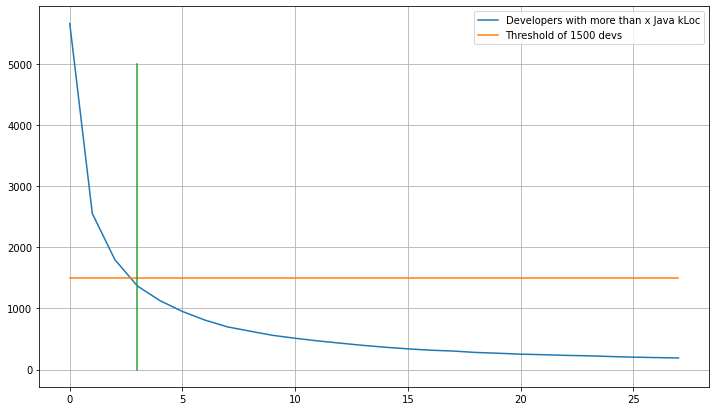

In [197]:
x = []
y = []
y2 = []
threshold = 1500
for i in range(28):
    result = dbUtils.runQuery('''
        SELECT COUNT(*) AS num
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc >= '''+str(i * 1000)+'''
    ''', True)
    x.append(i)
    y.append(result['num'][0])
    y2.append(1500)
    
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x, y2)
pyplot.plot([3, 3], [0, 5000])
pyplot.legend(['Developers with more than x Java kLoc', 'Threshold of '+str(threshold)+' devs'])
pyplot.savefig('javaDevPerLoc.png')

Old graph:

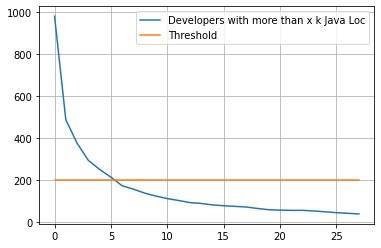

In [78]:
x = []
y = []
y2 = []
for i in range(28):
    result = dbUtils.runQuery('''
        SELECT COUNT(*) AS num
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc >= '''+str(i * 1000)+'''
    ''', True)
    x.append(i)
    y.append(result['num'][0])
    y2.append(200)
    
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x, y2)
pyplot.legend(['Developers with more than x k Java Loc', 'Threshold'])

In [139]:
javaUsers = dbUtils.runQuery('''
    DROP VIEW IF EXISTS crm20.lb_java_users;
    
    CREATE VIEW crm20.lb_java_users AS
        (SELECT *
        FROM crm20.lb_languages
        WHERE language = 'java' AND loc > 3000);
        
    SELECT * FROM crm20.lb_java_users
''')

Time used: 0.10370635986328125


In [140]:
display(javaUsers)

,author_id,language,loc,first_written
0,118,java,4458.0,2014-07-12 13:58:27
1,1361,java,52662.0,2014-08-23 09:58:05
2,4073,java,5481.0,2014-08-14 02:10:11
3,5768,java,191889.0,2010-08-04 18:11:50
4,10401,java,4762.0,2012-08-30 09:36:51
...,...,...,...,...
1361,49736842,java,3194.0,2019-03-01 08:29:23
1362,49975159,java,12942.0,2019-03-18 09:09:26
1363,50518011,java,11297.0,2019-04-09 18:20:00
1364,50573155,java,72624.0,2019-04-10 13:08:48


In [141]:
runQuery('''
        CREATE MATERIALIZED VIEW crm20.lb_polyglots AS
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC,  lb_java_users.first_written as javaStart, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC, ARRAY_AGG(lb_languages.first_written) as secStart
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
            HAVING lb_java_users.loc / 2 > ALL(ARRAY_AGG(lb_languages.loc))
            AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written)));
        SELECT * FROM crm20.lb_polyglots
''')

Time used: 0.5393450260162354


,author_id,javaloc,javastart,secondary_languages,secloc,secstart
0,55149,48533.0,2012-08-18 19:14:30,[js],[13340],[2015-08-10 01:20:42]
1,61025,231507.0,2010-12-17 19:50:34,[js],[1494],[2013-10-09 16:20:00]
2,89727,90236.0,2012-03-01 13:56:58,[js],[32537],[2013-02-10 15:10:56]
3,100010,4449.0,2013-08-21 21:01:11,[js],[1214],[2014-05-16 19:11:29]
4,100236,143991.0,2010-04-11 12:32:30,[js],[42598],[2015-01-31 21:20:39]
...,...,...,...,...,...,...
103,41410889,11749.0,2018-04-02 00:46:50,[js],[1263],[2018-04-13 04:04:22]
104,45852806,4813.0,2018-10-23 03:57:45,[py],[1928],[2018-11-09 02:44:09]
105,45985807,69531.0,2018-10-23 08:41:21,[js],[29569],[2018-10-23 08:57:52]
106,46354752,12717.0,2018-10-08 22:59:11,[js],[2197],[2018-10-09 13:36:55]


In [161]:
runQuery('''
        DROP MATERIALIZED VIEW IF EXISTS crm20.lb_controlgroup;
        CREATE MATERIALIZED VIEW crm20.lb_controlgroup AS (
            SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC,  lb_java_users.first_written as javaStart
            FROM crm20.lb_java_users
            WHERE author_id NOT IN (SELECT author_id FROM crm20.lb_languages WHERE (language = 'py' OR language = 'js'))
            AND MOD(author_id, 4) = 3 
            AND loc > 5000
        );
        SELECT * FROM crm20.lb_controlgroup
''')

Time used: 0.25896477699279785


,author_id,javaloc,javastart
0,16503,106978.0,2010-09-30 11:48:03
1,34131,174060.0,2010-07-22 11:55:16
2,99671,20371.0,2012-07-14 12:27:07
3,153911,5064.0,2013-11-19 15:26:37
4,338779,13707.0,2012-07-09 07:15:19
...,...,...,...
101,46946759,10000.0,2019-05-10 07:02:55
102,49175119,16300.0,2019-02-03 02:28:33
103,49975159,12942.0,2019-03-18 09:09:26
104,50518011,11297.0,2019-04-09 18:20:00


In [162]:
polyglotProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_polyglotProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_polyglots, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM  crm20.lb_polyglotProjects
''')
display(polyglotProjects)
controlgroupProjects = dbUtils.runQuery('''
    CREATE VIEW crm20.lb_controlgroupProjects AS (
        SELECT DISTINCT repo_id, url, name
        FROM lb_controlgroup, ght.project_members, ght.projects
        WHERE author_id = user_id
        AND repo_id = id
    );
    SELECT * FROM crm20.lb_controlgroupProjects
''')
display(controlgroupProjects)

Time used: 0.42659735679626465


,repo_id,url,name
0,1182,https://api.github.com/repos/twitter/scalding,scalding
1,1372,https://api.github.com/repos/twitter/finagle,finagle
2,3732,https://api.github.com/repos/ceylon/ceylon-ide...,ceylon-ide-eclipse
3,17827,https://api.github.com/repos/twitter/flockdb,flockdb
4,34552,https://api.github.com/repos/thiagoruis/dotNET...,dotNET-Grupo-2
...,...,...,...
989,131699833,https://api.github.com/repos/suimn416/2019.Spr...,2019.Spring.AI_BOSS
990,131979956,https://api.github.com/repos/capturetheworld/c...,cs151project
991,132564033,https://api.github.com/repos/idio/langdetect,langdetect
992,134135475,https://api.github.com/repos/luchizina/phpLuna,phpLuna


Time used: 0.35388851165771484


,repo_id,url,name
0,7589,https://api.github.com/repos/nxtbgthng/OAuth2C...,OAuth2Client
1,8612,https://api.github.com/repos/jboss-switchyard/...,components
2,17345,https://api.github.com/repos/jboss-switchyard/...,tools
3,23282,https://api.github.com/repos/cloudera/crunch,crunch
4,24828,https://api.github.com/repos/jboss-switchyard/...,quickstarts
...,...,...,...
378,128921855,https://api.github.com/repos/huangcs3/cloudtest,cloudtest
379,129200651,https://api.github.com/repos/wer345/vscodegit,vscodegit
380,129732012,https://api.github.com/repos/MatteoCultrera/Fo...,Foody_User
381,134529452,https://api.github.com/repos/mibaldi/Architect...,ArchitectCodersG3


---
# Statistics about user languages:

### How many users write n times as much Java code as their secondary language (but still 1000 LoC in Secondary!)

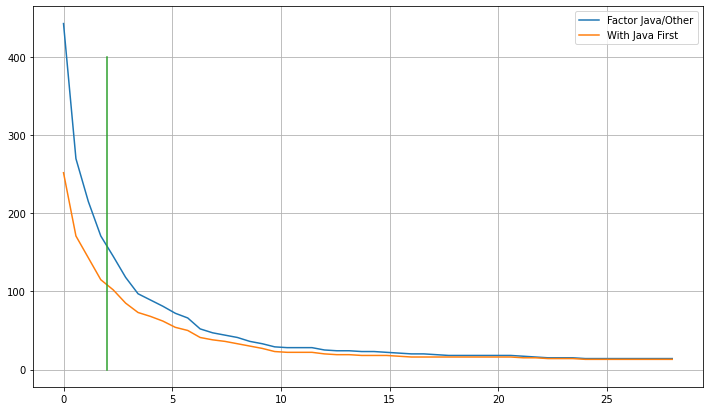

In [199]:
x = []
y = []

x2 = []
y2 = []
for i in numpy.linspace(0, 28, 50):
    result = dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))) AS x
    ''', True)
    x.append(result['factor'][0])
    y.append(result['devs'][0])
    
for i in numpy.linspace(0, 28, 50):
    result = dbUtils.runQuery('''
        SELECT '''+str(i)+''' AS factor, COUNT(author_id) AS devs FROM
            (SELECT lb_java_users.author_id, lb_java_users.loc AS javaLoC, ARRAY_AGG(lb_languages.language) AS secondary_languages, ARRAY_AGG(lb_languages.loc) AS secLoC
            FROM crm20.lb_java_users, crm20.lb_languages
            WHERE lb_java_users.author_id = lb_languages.author_id 
            AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
            GROUP BY lb_java_users.author_id, lb_java_users.loc, lb_java_users.first_written
            HAVING lb_java_users.loc >= ALL(ARRAY_AGG(lb_languages.loc * '''+str(i)+'''))
            AND lb_java_users.first_written < ALL(ARRAY_AGG(lb_languages.first_written))) AS x
    ''', True)
    x2.append(result['factor'][0])
    y2.append(result['devs'][0])
    
pyplot.figure(figsize=(12, 7))
pyplot.grid()
pyplot.plot(x, y)
pyplot.plot(x2, y2)
pyplot.plot([2,2], [0,400])
pyplot.legend(['Factor Java/Other', 'With Java First'])
pyplot.savefig('polyglotsPerFactor.png')

### Which secondary languages are there?

In [143]:
dbUtils.runQuery('''
    SELECT secondary_languages, COUNT(author_id)
    FROM
        (SELECT lb_java_users.author_id, ARRAY_AGG(lb_languages.language) AS secondary_languages
        FROM crm20.lb_java_users, crm20.lb_languages
        WHERE lb_java_users.author_id = lb_languages.author_id 
        AND (lb_languages.language = 'py' OR lb_languages.language = 'js') AND lb_languages.loc > 1000
        GROUP BY lb_java_users.author_id) AS secondaries
    GROUP BY secondary_languages
''')

Time used: 0.08953547477722168


,secondary_languages,count
0,[js],362
1,"[js, py]",32
2,[py],43
3,"[py, js]",6


## Number of developers per language (or file ending, more precisely)
Note: As there is no filtering for linecount > 0, this numbery may differ from the other ones

In [144]:
dbUtils.runQuery('''
    SELECT language, COUNT(author_id) AS devs
    FROM crm20.lb_languages
    GROUP BY language
    HAVING 
        language <> 'png' 
        AND language <> 'md' 
        AND language <> 'None' 
        AND language <> 'txt' 
        AND language <> 'gitignore' 
        AND language <> 'html' 
        AND language <> 'css'
        AND language <> 'scss'
        AND language <> 'xml'
        AND language <> 'json'
        AND language <> 'jpg'
        AND language <> 'yml'
        AND language <> 'svg'
        AND language <> 'ttf'
        AND language <> 'properties'
        AND language <> 'gif'
        AND language <> 'ico'
        AND language <> 'lock'
        AND language <> 'pdf'
    ORDER BY devs DESC
    LIMIT 30
''')

Time used: 0.17014098167419434


,language,devs
0,js,8792
1,java,5660
2,py,4097
3,php,3014
4,h,2536
5,sh,2243
6,woff,2176
7,cs,2117
8,eot,2106
9,rb,1874
